In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b84bfe20c8>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b84f523908>,
 'id': 1,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'station': 'USC00519397',
 'longitude': -157.8168}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
precipitation = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_df = pd.DataFrame(precipitation, columns=['Date','Precipitation'])

Precipindex = Precipitation_df.set_index('Date')

# Sort the dataframe by date
Precipordered = Precipindex.sort_values("Date", ascending=True)
Precipordered
# Use Pandas Plotting with Matplotlib to plot the data


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


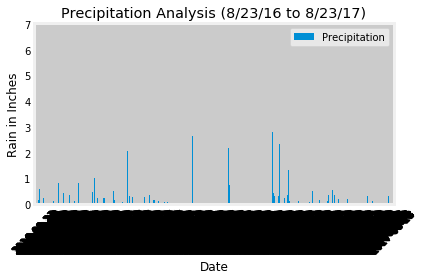

In [13]:
# Date = ['2016-08-23', '2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09', '2017-04-18', '2017-05-31' '2017-08-23']
# tick_locations = [0, 1, 2, 3, 4, 5, 6, 7, 8]
Precipordered.plot(kind="bar")
# plt.xticks(tick_locations, Date)
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(Precipordered["Precipitation"].describe())


      


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [15]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Station).group_by(Station.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
busy_station



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

busiestStation = busy_station[0][0]

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]
       
temperature = session.query(*sel).\
    filter(Measurement.station == busiestStation).all()
temperature




[(54.0, 85.0, 71.66378066378067, 2772)]

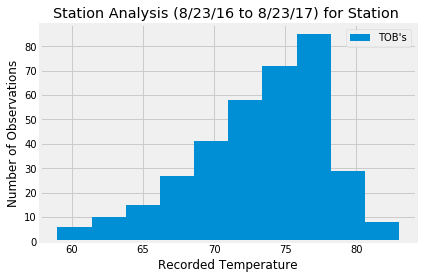

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Busytemperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiestStation).\
    filter(Measurement.date > "2016-08-23").\
    order_by(Measurement.date).all()


Busytemperature_df = pd.DataFrame(Busytemperature, columns=['Station','Date','TOB'])
Busytemperature_df

plt.hist(Busytemperature_df['TOB'])
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Observations")
plt.title("Station Analysis (8/23/16 to 8/23/17) for Station ")
plt.legend(["TOB's"])
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
